# Example how to analyze a gamma spectrum and blur data from a MegaLib simulation using gauss_fit

In [1]:
# jupyter specific magic operator
%pylab inline
import matplotlib.patches as mpatches
import becquerel as bq
import gauss_fit as gf

Populating the interactive namespace from numpy and matplotlib


In [2]:
fname = 'digibase_5min.Spe'
digital_0_1 = bq.Spectrum.from_file(gf.fix_spe_zero_cal(fname))
#Background Subtraction
fname_bg = 'digibase_bg.Spe'
digital_bg = bq.Spectrum.from_file(gf.fix_spe_zero_cal(fname_bg))
#spec_bg = spec_bg.counts_vals*time_1/time_2

Fixed line: 1046
SpeFile: Reading file digibase_5min_fixed.Spe
Unknown line:  $PRESETS:
Unknown line:  None
Unknown line:  0
Unknown line:  0
Fixed line: 1046
SpeFile: Reading file digibase_bg_fixed.Spe
Unknown line:  $PRESETS:
Unknown line:  None
Unknown line:  0
Unknown line:  0


# Background Subtraction

In [3]:
digital_1 = digital_0_1 - digital_bg

# Enter the isotopes used in the gamma analysis

In [4]:
energy_list = gf.gamma_energies('Cs137', 'Co60')

# Calibrate the spectrum
spectrum_calibration(digital_1.cpskev_vals, energy_list, channel_width, clean_right) generates the arrays for bequerel

In [5]:
channel_width = 10; clean_right = 90
channel_number, energies = gf.spectrum_calibration(digital_1.cpskev_vals, energy_list, channel_width, clean_right)

digital_cal = bq.LinearEnergyCal.from_points(chlist=channel_number, kevlist=energies)
digital_cal.update_fit()
digital_0_1.apply_calibration(digital_cal)
digital_bg.apply_calibration(digital_cal)

# Background subtract one more time 
Now that both data sets are calibrated correctly subtract out the background and plot the spectrum

/Users/Matt/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


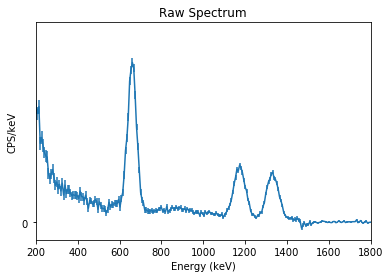

In [23]:
digital_1 = digital_0_1 - digital_bg
plt.errorbar(digital_1.energies_kev, digital_1.cpskev_vals, yerr=digital_1.cpskev_uncs)

plt.yscale('symlog')
plt.xlim(200, 1800)
plt.legend()
plt.ylabel('CPS/keV')
plt.xlabel('Energy (keV)')
plt.title('Raw Spectrum')

# Fitting the Data with a Gauss function and a linear subtraction

In [7]:
sigma, amplitude = gf.spectrum_gauss_fit(digital_1.energies_kev, digital_1.cpskev_vals, energy_list, channel_width)
print(sigma, amplitude)
amplitude_max = max(amplitude)

[20.91724175197078, 27.802602674598788, 29.723104543119415] [61.47173192295703, 28.67134653555825, 28.19815991318241]


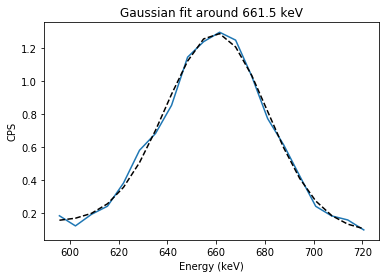

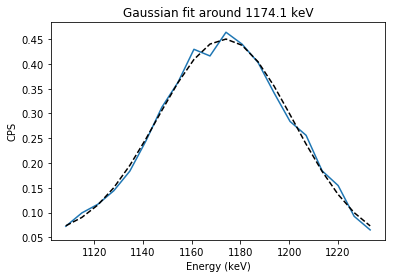

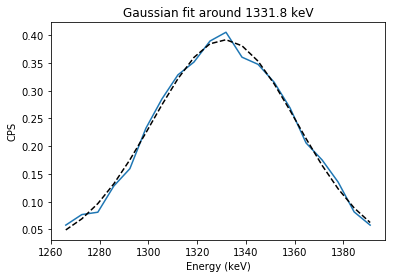

In [8]:
gf.plot_gauss(digital_1.energies_kev, digital_1.cpskev_vals, energy_list, channel_width)

# Plotting Resolution as a function of energy for Digital
The energy resolution vs sigma is fitted with a function that is forced to go through zero. The function of the fit is then used to smear the simulation data to match experimentation. 

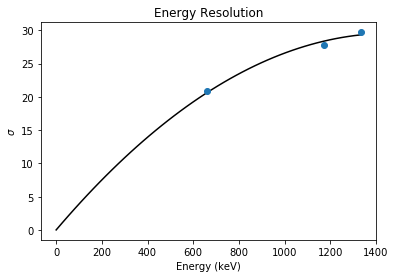

In [9]:
fit = gf.fit_nrg_resolution(sigma, energy_list)

# Analyze the Cosima output

In [17]:
sim = 'NaI_Tl.sim'

In [18]:
nrg = gf.cosima_output(sim)
print(nrg)
nrgsb_fast = gf.sim_blur(nrg, fit)
cnts, bin_edges = np.histogram(nrgsb_fast, bins=np.arange(0, 3001, 3))
bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2.

0
100000
[  661.67      661.67      661.67    ...,   627.42826   622.29591  1173.2    ]


# Gaussian fit to smeared data

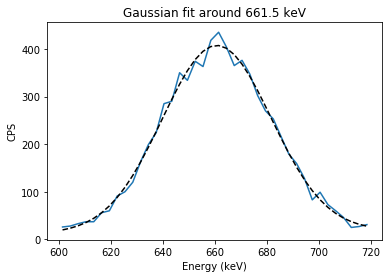

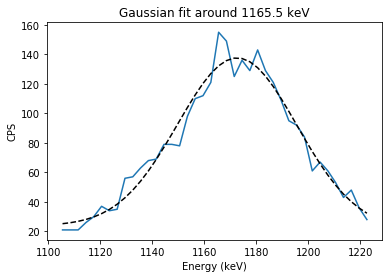

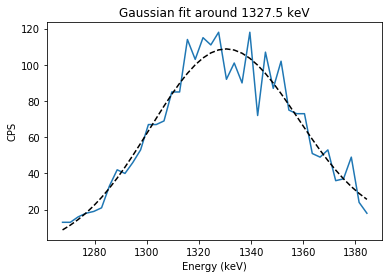

In [21]:
sigma_sim, amplitude_sim = gf.spectrum_gauss_fit(bin_centers, cnts, energy_list, 20)
gf.plot_gauss(bin_centers, cnts, energy_list, 20)

# Plot the smeared data and experimental data
Normalized to maximum peak height

Ultimately you need to compare the number of particles which were simulated to the number of particles emitted from the source. I normally compare detected CPS to source Bq because this is unambiguously defined for both the simulation and measurement. There are fancy ways to set a source activity in MEGAlib using activation sources but I don’t use these because it is a bit of a black box.

For Cs137 the proper photo peak count rate comparison will be the number of simulated detector hits (your simulated spectrum) divided by the number of simulated particles corrected to decay rate (via a branching ratio).  The measurement can be converted to cps/Bq easily. These units are the same between measurement and simulation so they can be compared.

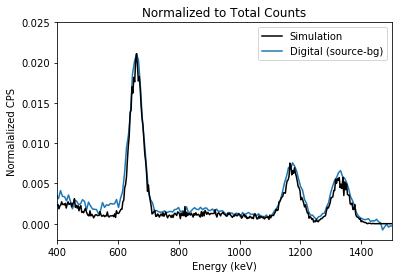

In [22]:
plt.plot(bin_centers, (cnts/max(amplitude_sim)), 'k', zorder = 10, label = 'Simulation')
plt.plot(digital_1.energies_kev, (digital_1.cpskev_vals/amplitude_max), label='Digital (source-bg)')

plt.xlim(400,1500,100)
plt.legend()
plt.xlabel('Energy (keV)')
plt.ylabel('Normalalized CPS/keV')
plt.title('Normalized to  Counts')